# **LAST PROJECT: IMAGE CLASSIFICATION MODEL DEPLOYMENT 👨🏽‍💻**

* Name         : Lintang Nagari
* Email        : unggullintangg@gmail.com
* Linkedin     : <a href='https://www.linkedin.com/in/lintangnagari/'>Lintang Nagari</a>
* Github       : <a href='https://github.com/lnt-ngr'>lnt-ngr</a>

**Here are the submission criteria you must meet:**

* Use any dataset, but it must have **at least 1000 images**.
* The dataset should not have been used in any previous machine learning submissions.
* Divide the dataset into **80% training set and 20% test set**.
* Model must use a `sequential model`.
* Model must include `Conv2D Maxpooling Layer`.
* Achieve **at least 80% accuracy** on both training and validation sets.
* Use Callbacks.
* Create plots for model accuracy and loss.
* Write code to save the model in *TF-Lite format*.

**Dataset : https://www.kaggle.com/datasets/shiv28/animal-5-mammal**

**About Dataset**

It contains about 15K medium quality animal images belonging to 10 categories: **dog, cat, horse, elephant ,lion**. All the images have been collected from `google images` and have been checked by human. There is some erroneous data to simulate real conditions (eg. images taken by users of your app).

### __IMPORT LIBRARY__

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications import InceptionV3, Xception, ResNet50V2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

print(tf.__version__)

2.15.0


### __DATASET__

In [58]:
# Dataset Train
dataset = '/content/drive/MyDrive/DATASET/animals/dataframe'

# Loop through each folder within the dataset directory
def list_dirs_and_files(directory_path):
    print('Folder and its number of files:')

    folders = [folder for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]
    total_files = 0
    total_folders = len(folders)

    for folder in folders:
        folder_path = os.path.join(directory_path, folder)
        files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
        file_count = len(files)
        total_files += file_count
        print(f"{folder} [{file_count}] files")

    print(f"\nTotal files in all folders: {total_files}")
    print(f"Total folders (label): {total_folders}")

print('\nDirectory dataset info')
list_dirs_and_files(dataset)

def list_various_resolutions(directory):
    folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    image_sizes = []

    for folder in folders:
        folder_path = os.path.join(directory, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                with Image.open(file_path) as image:
                    width, height = image.size
                    image_sizes.append(f'{width}x{height}')

    unique_sizes = set(image_sizes)
    first_size_unique = 8

    print(f'Size all images: {len(image_sizes)}')
    print(f'Size unique images: {len(unique_sizes)}')
    print(f'First {first_size_unique} unique images: {list(unique_sizes)[:first_size_unique]}')

print('\nList various resolutions')
list_various_resolutions(dataset)


Directory dataset info
Folder and its number of files:
elephant [2730] files
lion [2675] files
dog [2627] files
cat [2737] files
horse [2709] files

Total files in all folders: 13478
Total folders (label): 5

List various resolutions
Size all images: 13478
Size unique images: 774
First 8 unique images: ['1800x1799', '245x206', '1024x568', '1024x798', '217x232', '414x122', '1600x1085', '510x340']


## __DARA PREPROCESSING__

In [59]:
# Dataset
baseDir = '/content/drive/MyDrive/DATASET/animals/dataframe'
os.listdir(baseDir)

['elephant', 'lion', 'dog', 'cat', 'horse']

In [61]:
!pip install split-folders
import splitfolders as sf

# Split directory
sf.ratio(
    baseDir,
    output = os.path.join('/content/drive/MyDrive/DATASET/animals'),
    seed   = None,
    ratio  = (0.8, 0.2)
)

Copying files: 13478 files [05:19, 42.21 files/s]


In [62]:
imageDir = '/content/drive/MyDrive/DATASET/animals'

trainDirelephant  = os.path.join(imageDir, 'train/elephant')
trainDirlion      = os.path.join(imageDir, 'train/lion')
trainDirdog       = os.path.join(imageDir, 'train/dog')
trainDircat       = os.path.join(imageDir, 'train/cat')
trainDirhorse     = os.path.join(imageDir, 'train/horse')

valDirelephant    = os.path.join(imageDir, 'val/elephant')
valDirlion        = os.path.join(imageDir, 'val/lion')
valDirdog         = os.path.join(imageDir, 'val/dog')
valDircat         = os.path.join(imageDir, 'val/cat')
valDirhorse       = os.path.join(imageDir, 'val/horse')

In [63]:
# Count train and val image
trainSet = (
      len(os.listdir(trainDirelephant))
    + len(os.listdir(trainDirlion))
    + len(os.listdir(trainDirdog))
    + len(os.listdir(trainDircat))
    + len(os.listdir(trainDirhorse))
)

valSet = (
      len(os.listdir(valDirelephant))
    + len(os.listdir(valDirlion))
    + len(os.listdir(valDirdog))
    + len(os.listdir(valDircat))
    + len(os.listdir(valDirhorse))
)

print(f'Train Set      : {trainSet}')
print(f'Validation Set : {valSet}')

Train Set      : 10781
Validation Set : 2697


In [65]:
# List directory of train and validation image
train_dir = os.path.join(imageDir, 'train')
val_dir   = os.path.join(imageDir, 'val')

print(os.listdir(train_dir))
print(os.listdir(val_dir))

['elephant', 'lion', 'dog', 'cat', 'horse']
['elephant', 'lion', 'dog', 'cat', 'horse']


In [66]:
#Image Generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2,)

test_datagen = ImageDataGenerator(rescale=1./255)

In [67]:

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 64,
    shuffle = True,
    color_mode = 'rgb',
    class_mode = 'categorical',
)

val_gen = test_datagen.flow_from_directory(
    val_dir,
    target_size = (224, 224),
    batch_size = 64,
    shuffle = True,
    color_mode = 'rgb',
    class_mode = 'categorical',
)

Found 10781 images belonging to 5 classes.
Found 2697 images belonging to 5 classes.


## __MODELLING__

In [72]:
# Transfer Learning from ResNetv50
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

In [73]:
# model's architecture
model = tf.keras.models.Sequential([
    base_model,
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2,2)),
    Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2,2)),
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(2048, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(128, activation = 'relu'),
    Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 conv2d_121 (Conv2D)         (None, 7, 7, 128)         2359424   
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 3, 3, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_122 (Conv2D)         (None, 3, 3, 256)         295168    
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 1, 1, 256)         0         
 ng2D)                                                           
                                                                 
 global_average_pooling2d_1  (None, 256)             

In [74]:
# Compiling the model
model.compile(
    loss ='categorical_crossentropy',
    optimizer = tf.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

## __CALLBACK__

In [75]:
# Stop training callback
class stopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
            print('\nAccuracy and Validation Accuracy reach > 92%')
            self.model.stop_training = True

MyCallbacks = stopCallback()

# ReduceLROnPlateau callback
reduceLROP   = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


## __FUNGSI FIT__

In [76]:
epoch_number = 50
history = model.fit(
    train_gen,
    epochs = epoch_number,
    steps_per_epoch = 16,
    validation_data = val_gen,
    validation_steps = 16,
    callbacks = [MyCallbacks, reduceLROP],
    verbose = 2,
)

Epoch 1/50
16/16 - 62s - loss: 0.8981 - accuracy: 0.6249 - val_loss: 2.0312 - val_accuracy: 0.6924 - lr: 0.0010 - 62s/epoch - 4s/step
Epoch 2/50
16/16 - 30s - loss: 0.5021 - accuracy: 0.8125 - val_loss: 0.3898 - val_accuracy: 0.9102 - lr: 0.0010 - 30s/epoch - 2s/step
Epoch 3/50
16/16 - 31s - loss: 0.4930 - accuracy: 0.8291 - val_loss: 0.3444 - val_accuracy: 0.9102 - lr: 0.0010 - 31s/epoch - 2s/step
Epoch 4/50
16/16 - 29s - loss: 0.3845 - accuracy: 0.8428 - val_loss: 0.2671 - val_accuracy: 0.9258 - lr: 0.0010 - 29s/epoch - 2s/step
Epoch 5/50
16/16 - 27s - loss: 0.4426 - accuracy: 0.8398 - val_loss: 0.2276 - val_accuracy: 0.9434 - lr: 0.0010 - 27s/epoch - 2s/step
Epoch 6/50
16/16 - 28s - loss: 0.4102 - accuracy: 0.8535 - val_loss: 0.1999 - val_accuracy: 0.9404 - lr: 0.0010 - 28s/epoch - 2s/step
Epoch 7/50
16/16 - 30s - loss: 0.3888 - accuracy: 0.8613 - val_loss: 0.1509 - val_accuracy: 0.9502 - lr: 0.0010 - 30s/epoch - 2s/step
Epoch 8/50
16/16 - 27s - loss: 0.3755 - accuracy: 0.8613 - val

## __PLOTTING__

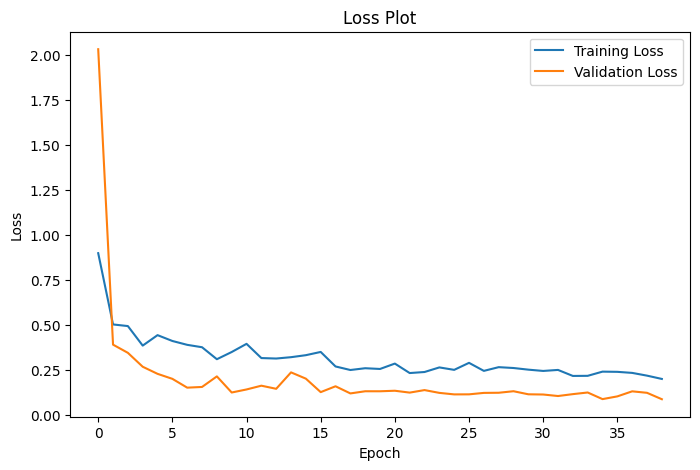

In [77]:
#loss Plot
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

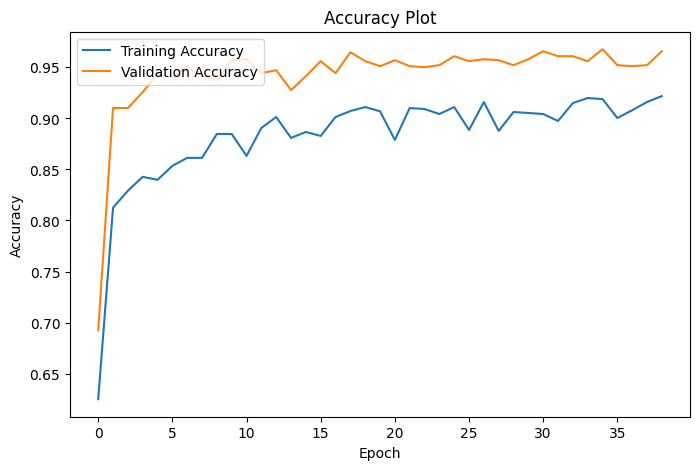

In [78]:
#Accuracy Plot
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## __SAVE MODEL TF-LITE__

In [79]:
import warnings

warnings.filterwarnings('ignore') # Ignore Warning

# Convert model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with tf.io.gfile.GFile('Animal_ClassV1.tflite', 'wb') as f:
  f.write(tflite_model)

In [80]:
from google.colab import files

# Download the flower model
files.download('/content/Animal_ClassV1.tflite')

print('`model.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`model.tflite` has been downloaded
